In [ ]:
import tensorflow as tf

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data/pjt2

/content/drive/MyDrive/data/pjt2


In [ ]:
import pandas as pd
import numpy as np
train = pd.read_csv('data/train_final.csv')
test = pd.read_csv('data/test_final.csv')

In [ ]:
x_train = train.new_title
y_train = train.topic_idx
x_test = test.new_title

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_word = 19100
t = Tokenizer(num_words= num_word)
t.fit_on_texts(x_train)

s = t.texts_to_sequences(x_train)
s_test = t.texts_to_sequences(x_test)

max_len = 25
pad_X_train = pad_sequences(s, maxlen=max_len, padding = 'pre')
pad_X_test = pad_sequences(s_test, maxlen=max_len, padding = 'pre')

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, num_word, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(7, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from sklearn.model_selection import train_test_split

X_tn, X_tt, y_tn, y_tt = train_test_split(pad_X_train, y_train, test_size=0.33, random_state=2021)

In [ ]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, num_word, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(7, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/data/pjt2/model/trans/trans_model.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

history = model.fit(X_tn, y_tn, batch_size=32, epochs=10,
                    validation_data = (X_tt,y_tt),
                    callbacks=[es, mc])

Epoch 1/10
1119/1119 [==============================] - 10s 7ms/step - loss: 0.8037 - accuracy: 0.7258 - val_loss: 0.4385 - val_accuracy: 0.8584
Epoch 2/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.3241 - accuracy: 0.9000 - val_loss: 0.4412 - val_accuracy: 0.8619
Epoch 3/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.2038 - accuracy: 0.9365 - val_loss: 0.5092 - val_accuracy: 0.8542
Epoch 4/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.1469 - accuracy: 0.9547 - val_loss: 0.6035 - val_accuracy: 0.8487
Epoch 5/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.1109 - accuracy: 0.9666 - val_loss: 0.6997 - val_accuracy: 0.8399
Epoch 6/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.0880 - accuracy: 0.9725 - val_loss: 0.7553 - val_accuracy: 0.8368
Epoch 7/10
1119/1119 [==============================] - 7s 6ms/step - loss: 0.0696 - accuracy: 0.9781 - val_loss: 0.8354 - val_accuracy

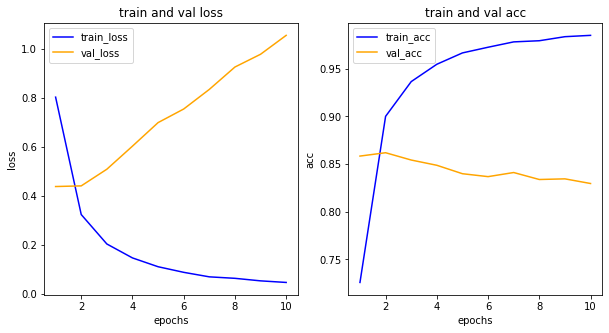

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/data/pjt2/model/trans/trans_model.h5')
model2.evaluate(pad_X_train, y_train, verbose=2)

In [ ]:
pre =model.predict(pad_X_test)
pre_index = [np.argmax(i) for i in pre]

sub_df = pd.read_csv('sample_submission.csv')

sub_df['topic_idx'] = pre_index
sub_df.to_csv('predict_trans_final_best.csv', index=False)